In [14]:
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import os

from src.data.data_loader import load_average_pts
from src.features.data_engineering import preprocess_seasons_data
from src.features.data_engineering import reverse_processing

from src.modeling.train_model import train_mlp_model
from src.modeling.predictions import merge_reversed_data_with_predictions
from src.modeling.evaluate_squad import squad_selection_without_constraints
from src.modeling.evaluate_squad import get_average_pts
from src.modeling.evaluate_squad import evaluate_selected_squad_without_constraints

In [15]:
average_pts = load_average_pts()

In [16]:
average_pts.head()

,GW,AVG_PTS_2016/17,AVG_PTS_2018/19,AVG_PTS_2021/22
0,1,44,53,69
1,2,56,59,56
2,3,40,48,54
3,4,41,43,57
4,5,47,46,55


## Train two separate models (GK and Field_players)

In [17]:
# load data by position
data_intermediate_path = os.path.dirname(os.getcwd()) + '\\data\\intermediate\\'

data_gk = pd.read_csv(data_intermediate_path + 'separate/gk_full.csv')
data_field = pd.read_csv(data_intermediate_path + 'separate/field_full.csv')

In [18]:
rolling_columns_gk = ['bonus', 'bps', 'clean_sheets', 'goals_conceded', 'influence', 'minutes',
                      'penalties_saved', 'saves', 'selected', 'player_team_score', 'opponent_team_score',
                      'total_points', 'transfers_in', 'transfers_out','value']

rolling_columns_field = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

times = ['all', 6, 3]

test_subset_XL = (['2016-17', [4, 8, 9, 14, 18, 20, 21, 26, 32]], ['2018-19', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], ['2021-22', [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [19]:
(x_train_gk, y_train_gk), (x_test_gk, y_test_gk), (x_train_target_gk, x_test_target_gk), x_scaler_gk = preprocess_seasons_data(data_gk, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_gk, rolling_times=times, opponent_team_stats=True)

(x_train_field, y_train_field), (x_test_field, y_test_field), (x_train_target_field, x_test_target_field), x_scaler_field = preprocess_seasons_data(data_field, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_field, rolling_times=times, opponent_team_stats=True)

In [20]:
class HyperModel(kt.HyperModel):
    def build(self, hp):
        model = tf.keras.models.Sequential()
        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 6)):
            model.add(
                tf.keras.layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=32, max_value=1024, step=64),
                    activation='relu'
                )
            )
            if hp.Boolean(f"dropout_{i}"):
                model.add(tf.keras.layers.Dropout(rate=round(hp.Float(f"dropout_{i}_rate", min_value=0.05, max_value=0.75, sampling="log"), 2)))

        model.add(tf.keras.layers.Dense(units=1, activation='linear'))
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="mae"
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 128, 256, 512]),
            validation_split=0.2,
            **kwargs,
        )

## Do hyperparameter tuning for the GK model

In [23]:
tuner_gk = kt.RandomSearch(
    hypermodel=HyperModel(),
    objective="val_loss",
    max_trials=200,
    overwrite=True,
    directory="hyperparameter_tuning_gk",
    project_name="fpl_ai_manager",
)

tuner_gk.search(x_train_gk, y_train_gk, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True)])

Trial 200 Complete [00h 00m 08s]
val_loss: 0.6298946142196655

Best val_loss So Far: 0.6223547458648682
Total elapsed time: 00h 41m 32s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner_gk.results_summary(num_trials=2)

Results summary
Results in hyperparameter_tuning_gk\fpl_ai_manager
Showing 2 best trials
Trial summary
Hyperparameters:
num_layers: 4
units_0: 736
dropout_0: False
lr: 0.002059822093051443
dropout_0_rate: 0.25646403472473245
units_1: 480
dropout_1: False
units_2: 288
dropout_2: True
batch_size: 32
units_3: 608
dropout_3: True
units_4: 608
dropout_4: False
units_5: 992
dropout_5: True
dropout_1_rate: 0.3484659412266646
dropout_2_rate: 0.20022483816970743
dropout_3_rate: 0.34820177396389373
dropout_5_rate: 0.4017435190819537
dropout_4_rate: 0.08965221937852047
Score: 0.6223547458648682
Trial summary
Hyperparameters:
num_layers: 5
units_0: 608
dropout_0: False
lr: 0.0010923729112669298
dropout_0_rate: 0.2841554198768544
units_1: 928
dropout_1: False
units_2: 608
dropout_2: False
batch_size: 32
units_3: 224
dropout_3: False
units_4: 992
dropout_4: True
units_5: 608
dropout_5: False
dropout_1_rate: 0.4974783026495302
dropout_2_rate: 0.42751401816646645
dropout_3_rate: 0.7137775505590893
dro

## Do hyperparameter tuning for the Field_players model

In [25]:
tuner_field = kt.RandomSearch(
    hypermodel=HyperModel(),
    objective="val_loss",
    max_trials=200,
    overwrite=True,
    directory="hyperparameter_tuning_field",
    project_name="fpl_ai_manager",
)

tuner_field.search(x_train_field, y_train_field, epochs=100,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6, restore_best_weights=True)])

Trial 107 Complete [00h 01m 32s]
val_loss: 1.0586438179016113

Best val_loss So Far: 0.9512856006622314
Total elapsed time: 04h 04m 49s

Search: Running Trial #108

Value             |Best Value So Far |Hyperparameter
4                 |5                 |num_layers
800               |992               |units_0
False             |False             |dropout_0
0.0054596         |0.00045776        |lr
736               |96                |units_1
True              |False             |dropout_1
288               |288               |units_2
False             |True              |dropout_2
352               |672               |units_3
True              |True              |dropout_3
16                |16                |batch_size
0.32604           |0.15669           |dropout_1_rate
0.17566           |0.076784          |dropout_2_rate
0.20376           |0.13437           |dropout_0_rate
0.50053           |0.092176          |dropout_3_rate
416               |96                |units_4
False    

KeyboardInterrupt: 

In [26]:
tuner_field.results_summary(num_trials=2)

Results summary
Results in hyperparameter_tuning_field\fpl_ai_manager
Showing 2 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 992
dropout_0: False
lr: 0.0004577633524435351
units_1: 96
dropout_1: False
units_2: 288
dropout_2: True
units_3: 672
dropout_3: True
batch_size: 16
dropout_1_rate: 0.15669079678413356
dropout_2_rate: 0.07678359298657673
dropout_0_rate: 0.13437127454747308
dropout_3_rate: 0.09217550577442386
units_4: 96
dropout_4: False
units_5: 992
dropout_5: False
dropout_4_rate: 0.10110543799218573
dropout_5_rate: 0.16445848875077773
Score: 0.9512856006622314
Trial summary
Hyperparameters:
num_layers: 2
units_0: 608
dropout_0: False
lr: 0.008664281726338777
units_1: 864
dropout_1: False
units_2: 800
dropout_2: True
units_3: 800
dropout_3: False
batch_size: 256
dropout_1_rate: 0.24817136387234712
dropout_2_rate: 0.0722059121568733
dropout_0_rate: 0.14183793357764835
dropout_3_rate: 0.23915904716408898
units_4: 416
dropout_4: True
units_5: 96
dropout_5: True

## Train models with best hyperparameters and evaluate them

In [62]:
# # Make predictions on specific test subset using MLP and XGBoost models
# model_mlp_gk, x_test_reversed_gk = train_baseline_mlp(x_train_gk, y_train_gk, x_test_gk, x_scaler_gk, x_test_target_gk)
# predictions_mlp_gk = merge_reversed_data_with_predictions(model_mlp_gk, x_test_gk, y_test_gk, x_test_reversed_gk)
#
# model_mlp_field, x_test_reversed_field = train_baseline_mlp(x_train_field, y_train_field, x_test_field, x_scaler_field, x_test_target_field)
# predictions_mlp_field = merge_reversed_data_with_predictions(model_mlp_field, x_test_field, y_test_field, x_test_reversed_field)
#
# # concatenate predictions_mlp_gk with predictions_mlp_def, predictions_mlp_mid and predictions_mlp_fwd
# predictions_mlp_merged_field = pd.concat([predictions_mlp_gk, predictions_mlp_field])

In [63]:
# # Get squad and evaluate it for both models
# results_mlp_field, selected_squad_points_mlp_field, real_player_average_points_mlp_field, season_gameweeks_mlp_field = evaluate_selected_squad_without_constraints(predictions_mlp_merged_field, test_subset_XL, 'mlp_model-no_constraints_FIELD_test_subset_XL')

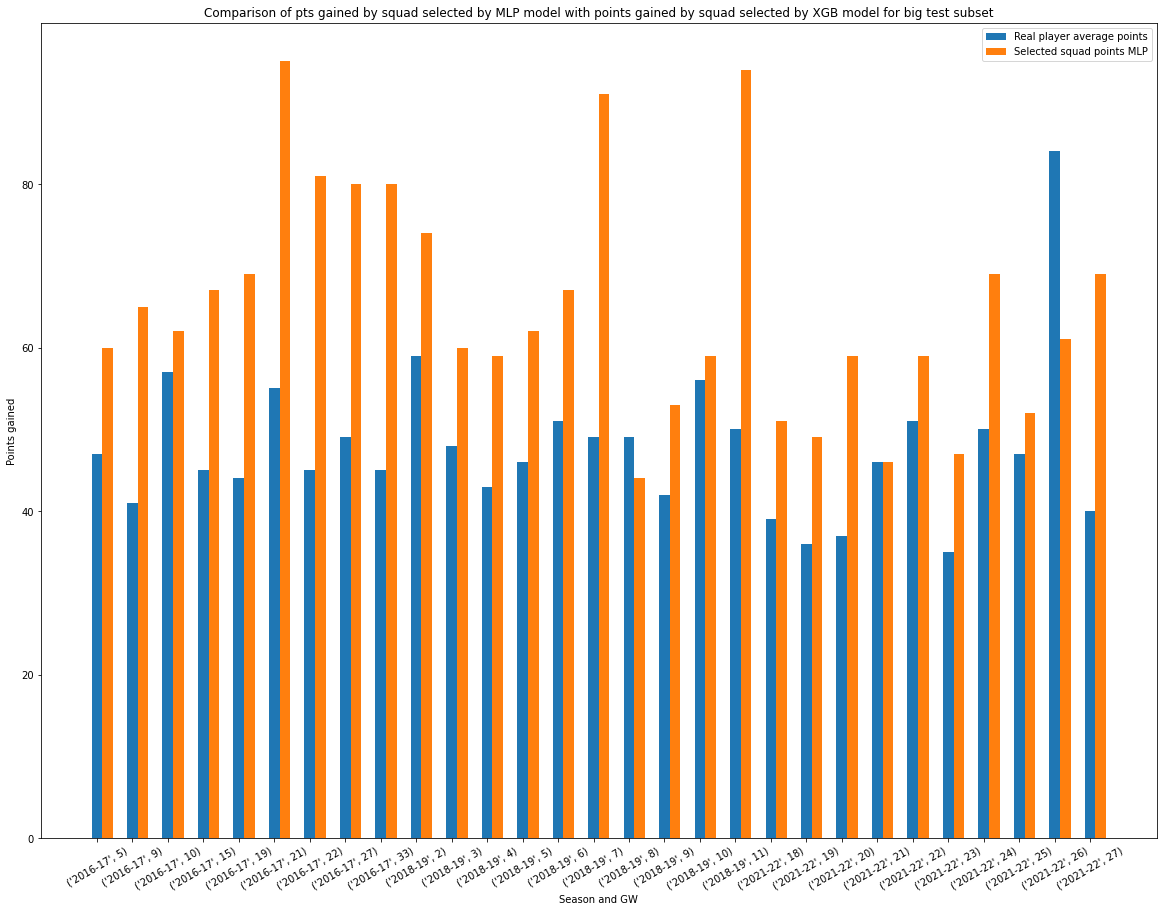

In [64]:
# plt.figure(figsize=(20,15))
#
# X_axis = np.arange(len(season_gameweeks_mlp_field))
#
# plt.bar(X_axis, real_player_average_points_mlp_field, 0.3, label = 'Real player average points')
# plt.bar(X_axis + 0.3, selected_squad_points_mlp_field, 0.3, label = 'Selected squad points MLP')
#
# plt.xticks(X_axis, season_gameweeks_mlp_field, rotation=30)
# plt.xlabel("Season and GW")
# plt.ylabel("Points gained")
# plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
# plt.legend()
# plt.show()

#### MLP model sum of points

In [65]:
# print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp_field))
# print('Sum of points gained by real players:', sum(real_player_average_points_mlp_field))
# print('Difference:', sum(selected_squad_points_mlp_field) - sum(real_player_average_points_mlp_field), 'pts')

Sum of points gained by selected squad: 1884.0
Sum of points gained by real players: 1386
Difference: 498.0 pts
